In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy as sp
from scipy import sparse, io
import re

/home/sennis/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data was downloaded from [Human Cell Landscape website](http://bis.zju.edu.cn/HCL/dpline.html?tissue=Bone-Marrow). Just downloaded Adult Bone Marrow 1&2. Data comes as a dge matrix with raw counts and a separate annotation file.

In [2]:
# read in raw counts, meta data and merge two samples
adata1 = sc.read_csv('../data/han/Adult-Bone-Marrow1_dge.txt', first_column_names = True).T
adata1.obs = pd.read_csv('../data/han/Adult-Bone-Marrow1_Anno.csv', index_col=0)
adata2 = sc.read_csv('../data/han/Adult-Bone-Marrow2_dge.txt', first_column_names = True).T
adata2.obs = pd.read_csv('../data/han/Adult-Bone-Marrow2_Anno.csv', index_col=0)
adata = adata1.concatenate([adata2], batch_key='sample_ID', batch_categories=['BoneMarrow_1', 'BoneMarrow_2'])
adata

AnnData object with n_obs × n_vars = 8704 × 11561
    obs: 'cluster', 'Tissue', 'CT', 'sample_ID'

/home/sennis/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/sennis/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/sennis/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/sennis/anaconda3/lib/python3.

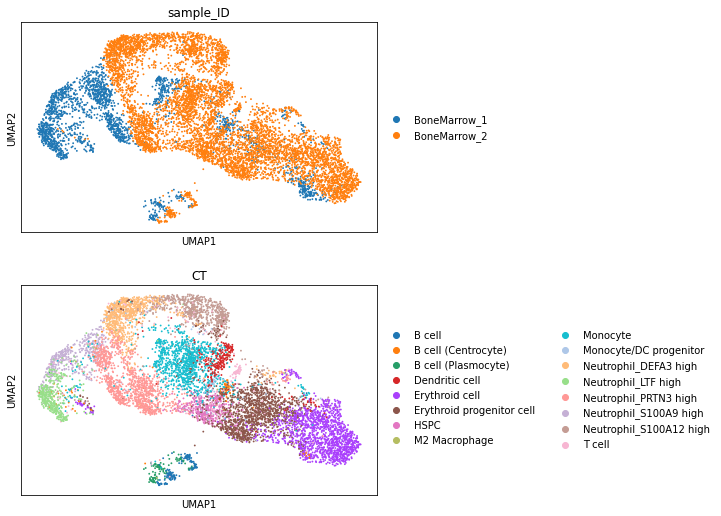

In [3]:
# normalise and visualise
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['sample_ID', 'CT'], ncols=1)

In [4]:
# save data
adata.write('../data/han/han.h5ad')

-------------------
I used `../rscripts/singleR.R` to predict cell type labels in this dataset. Will load them in and see how they compare with the original cell type labels.

In [5]:
# read in data and predicted labels
adata = sc.read('../data/han/han.h5ad')
labs = pd.read_csv('../data/han/han_cell_labels.csv', sep='\t')
adata.obs['celltype'] = labs['label']

... storing 'celltype' as categorical


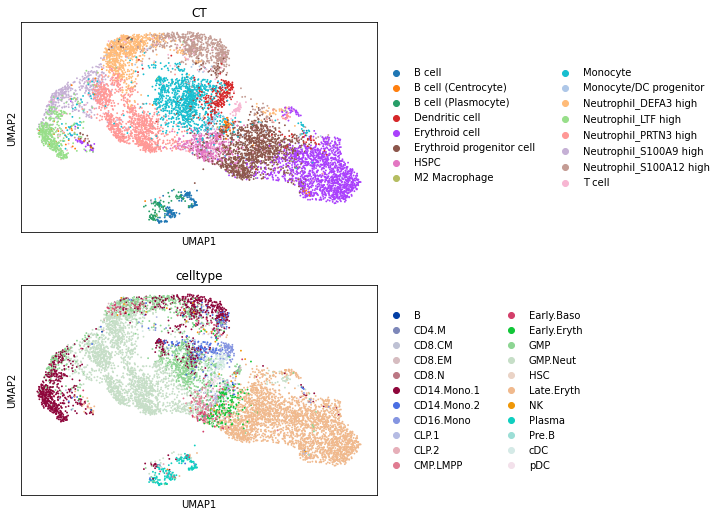

In [6]:
sc.pl.umap(adata, color=['CT', 'celltype'], ncols=1)

In [7]:
adata.obs['celltype'].value_counts()

Late.Eryth     2767
GMP.Neut       2222
CD14.Mono.1    1128
GMP            1097
Early.Eryth     207
Plasma          188
CD14.Mono.2     180
Early.Baso      165
cDC             165
CD16.Mono       160
CMP.LMPP        155
CLP.1            85
pDC              69
NK               35
Pre.B            25
HSC              15
CD4.M            11
B                 9
CD8.CM            7
CLP.2             6
CD8.EM            6
CD8.N             2
Name: celltype, dtype: int64

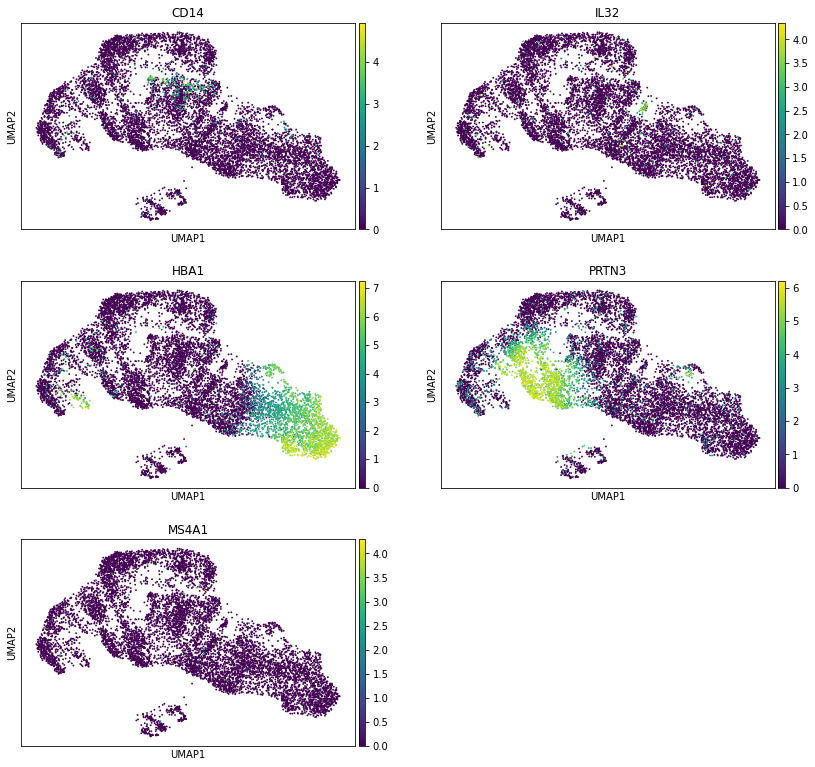

In [8]:
# make sure cells are expressing the genes you'd expect
sc.pl.umap(adata, color=['CD14', 'IL32', 'HBA1', 'PRTN3', 'MS4A1'], ncols=2)

In [9]:
# save data with cell type labels
adata.write('../data/han/han.h5ad')